**Assignment 4: Random Forest & Gradient Boosting**

In [9]:
import time

In [1]:
# MSDS 422
# Professor Chaturvedi
# October 2020

<div style="text-align: right"><b>pkg imports and reading file</b></div>

In [2]:
# basx
import numpy as np
import pandas as pd
import seaborn as sns

# standardizing ... scaling
from statistics import mean, stdev

# training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

# modeling
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# scoring
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  
from sklearn.model_selection import cross_val_score
from math import sqrt

# honestly dunno what this does
from sklearn.datasets import make_moons

%matplotlib inline   
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pd.options.display.float_format = "{:,.4f}".format

In [4]:
#from google.colab import drive 
#drive.mount('/content/gdrive')
#boston_input = pd.read_csv('gdrive/My Drive/Colab Notebooks/boston.csv')

In [5]:
boston = pd.read_csv("Data/boston.csv")

In [6]:
# goal : to predict mv, median value home price in 1970's $
responseVar = ["mv"]

In [7]:
cols_to_drop = ["neighborhood"]

<div style="text-align: right"><b>eda</b></div>

In [8]:
boston.head(2)

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.0063,18.0000,2.3100,0,0.5380,6.5750,65.2000,4.0900,1,296,15.3000,4.9800,24.0000
1,Swampscott,0.0273,0.0000,7.0700,0,0.4690,6.4210,78.9000,4.9671,2,242,17.8000,9.1400,21.6000


In [9]:
boston.tail(2)

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
504,Winthrop,0.1096,0.0000,11.9300,0,0.5730,6.7940,89.3000,2.3889,1,273,21.0000,6.4800,22.0000
505,Winthrop,0.0474,0.0000,11.9300,0,0.5730,6.0300,80.8000,2.5050,1,273,21.0000,7.8800,19.0000


In [10]:
# summary stats on explanatory vars, numeric
boston.loc[:, boston.columns != responseVar[0]].describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
count,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000
mean,3.6135,11.3636,11.1368,0.0692,0.5547,6.2846,68.5749,3.7950,9.5494,408.2372,18.4555,12.6531
std,8.6015,23.3225,6.8604,0.2540,0.1159,0.7026,28.1489,2.1057,8.7073,168.5371,2.1649,7.1411
min,0.0063,0.0000,0.4600,0.0000,0.3850,3.5610,2.9000,1.1296,1.0000,187.0000,12.6000,1.7300
25%,0.0820,0.0000,5.1900,0.0000,0.4490,5.8855,45.0250,2.1002,4.0000,279.0000,17.4000,6.9500
50%,0.2565,0.0000,9.6900,0.0000,0.5380,6.2085,77.5000,3.2074,5.0000,330.0000,19.0500,11.3600
75%,3.6771,12.5000,18.1000,0.0000,0.6240,6.6235,94.0750,5.1884,24.0000,666.0000,20.2000,16.9550
max,88.9762,100.0000,27.7400,1.0000,0.8710,8.7800,100.0000,12.1265,24.0000,711.0000,22.0000,37.9700


In [11]:
# summary stats on explanatory vars, categorical
boston.select_dtypes('object').describe(include='all')

,neighborhood
count,506
unique,93
top,Cambridge
freq,30


In [12]:
# summary stats on response var, whatever it is (numeric)
pd.DataFrame(boston[responseVar[0]].describe())

,mv
count,506.0000
mean,22.5289
std,9.1822
min,5.0000
25%,17.0250
50%,21.2000
75%,25.0000
max,50.0000


In [13]:
for col in cols_to_drop:
    if col in list(boston.columns):
        boston.drop(columns = [col], inplace = True)
    else:
        print(col, "already dropped . . ")

In [14]:
boston.head(2)

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0.0063,18.0000,2.3100,0,0.5380,6.5750,65.2000,4.0900,1,296,15.3000,4.9800,24.0000
1,0.0273,0.0000,7.0700,0,0.4690,6.4210,78.9000,4.9671,2,242,17.8000,9.1400,21.6000


<div style="text-align: right"><b>scale</b></div>

In [15]:
# changing tax to a type float for no particular reason
boston.tax = boston.tax.astype("float64")

In [16]:
normalized = boston.apply(lambda x: (x - min(x))/(max(x) - min(x)), axis=1)

In [17]:
normalized.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000
mean,0.0058,0.0394,0.0271,0.0002,0.0015,0.0182,0.1824,0.0119,0.0201,1.0000,0.0519,0.0325,0.0689
std,0.0128,0.0832,0.0174,0.0008,0.0005,0.0075,0.0895,0.0087,0.0107,0.0000,0.0186,0.0180,0.0440
min,0.0000,0.0000,0.0018,0.0000,0.0008,0.0053,0.0124,0.0017,0.0024,1.0000,0.0283,0.0043,0.0075
25%,0.0003,0.0000,0.0181,0.0000,0.0011,0.0102,0.1258,0.0039,0.0126,1.0000,0.0303,0.0213,0.0340
50%,0.0008,0.0000,0.0272,0.0000,0.0015,0.0187,0.1502,0.0108,0.0155,1.0000,0.0492,0.0290,0.0647
75%,0.0061,0.0402,0.0272,0.0000,0.0018,0.0230,0.2386,0.0181,0.0360,1.0000,0.0671,0.0387,0.0875
max,0.1336,0.4813,0.1364,0.0050,0.0031,0.0406,0.5160,0.0648,0.0360,1.0000,0.1016,0.1450,0.2591


In [18]:
normalized.head(2)

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0.0000,0.0608,0.0078,0.0000,0.0018,0.0222,0.2203,0.0138,0.0034,1.0000,0.0517,0.0168,0.0811
1,0.0001,0.0000,0.0292,0.0000,0.0019,0.0265,0.3260,0.0205,0.0083,1.0000,0.0736,0.0378,0.0893


In [19]:
standardized = boston.apply(lambda x: (x - mean(x)) / stdev(x))

In [20]:
standardized.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000,506.0000
mean,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-0.4194,-0.4872,-1.5563,-0.2723,-1.4644,-3.8764,-2.3331,-1.2658,-0.9819,-1.3127,-2.7047,-1.5296,-1.9090
25%,-0.4106,-0.4872,-0.8668,-0.2723,-0.9121,-0.5681,-0.8366,-0.8049,-0.6373,-0.7668,-0.4876,-0.7986,-0.5994
50%,-0.3903,-0.4872,-0.2109,-0.2723,-0.1441,-0.1084,0.3171,-0.2790,-0.5225,-0.4642,0.2746,-0.1811,-0.1447
75%,0.0074,0.0487,1.0150,-0.2723,0.5981,0.4823,0.9059,0.6617,1.6596,1.5294,0.8058,0.6024,0.2691
max,9.9241,3.8005,2.4202,3.6648,2.7296,3.5515,1.1164,3.9566,1.6596,1.7964,1.6372,3.5453,2.9918


In [21]:
standardized.head(2)

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,-0.4194,0.2845,-1.2866,-0.2723,-0.1441,0.4133,-0.1199,0.1401,-0.9819,-0.6659,-1.4576,-1.0745,0.1602
1,-0.4169,-0.4872,-0.5928,-0.2723,-0.7395,0.1941,0.3668,0.5566,-0.8670,-0.9864,-0.3028,-0.4920,-0.1012


In [22]:
# choosing to use standardized bc for some reason normalizing broke tax
scaled = standardized

del(normalized)
del(standardized)

<div style="text-align: right"><b>viz</b></div>

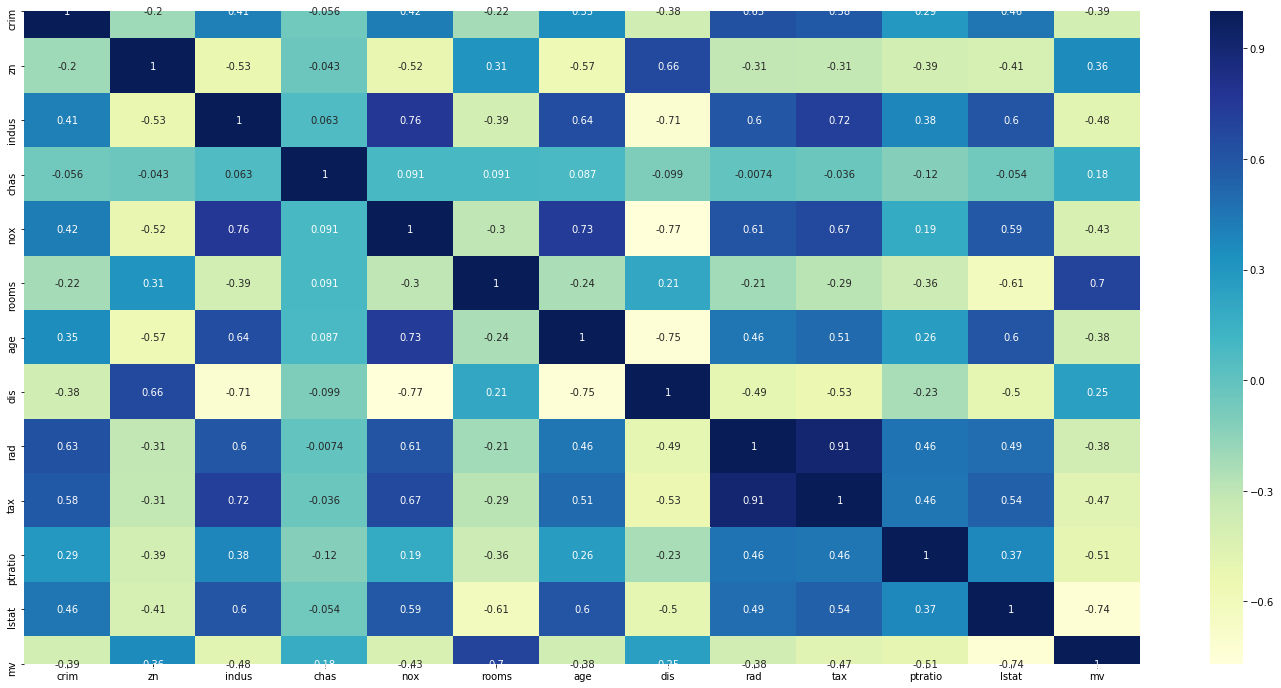

In [24]:
# corr'ns
plt.figure(figsize=(25,12))
sns.heatmap(scaled.corr(), annot=True, cmap="YlGnBu", )

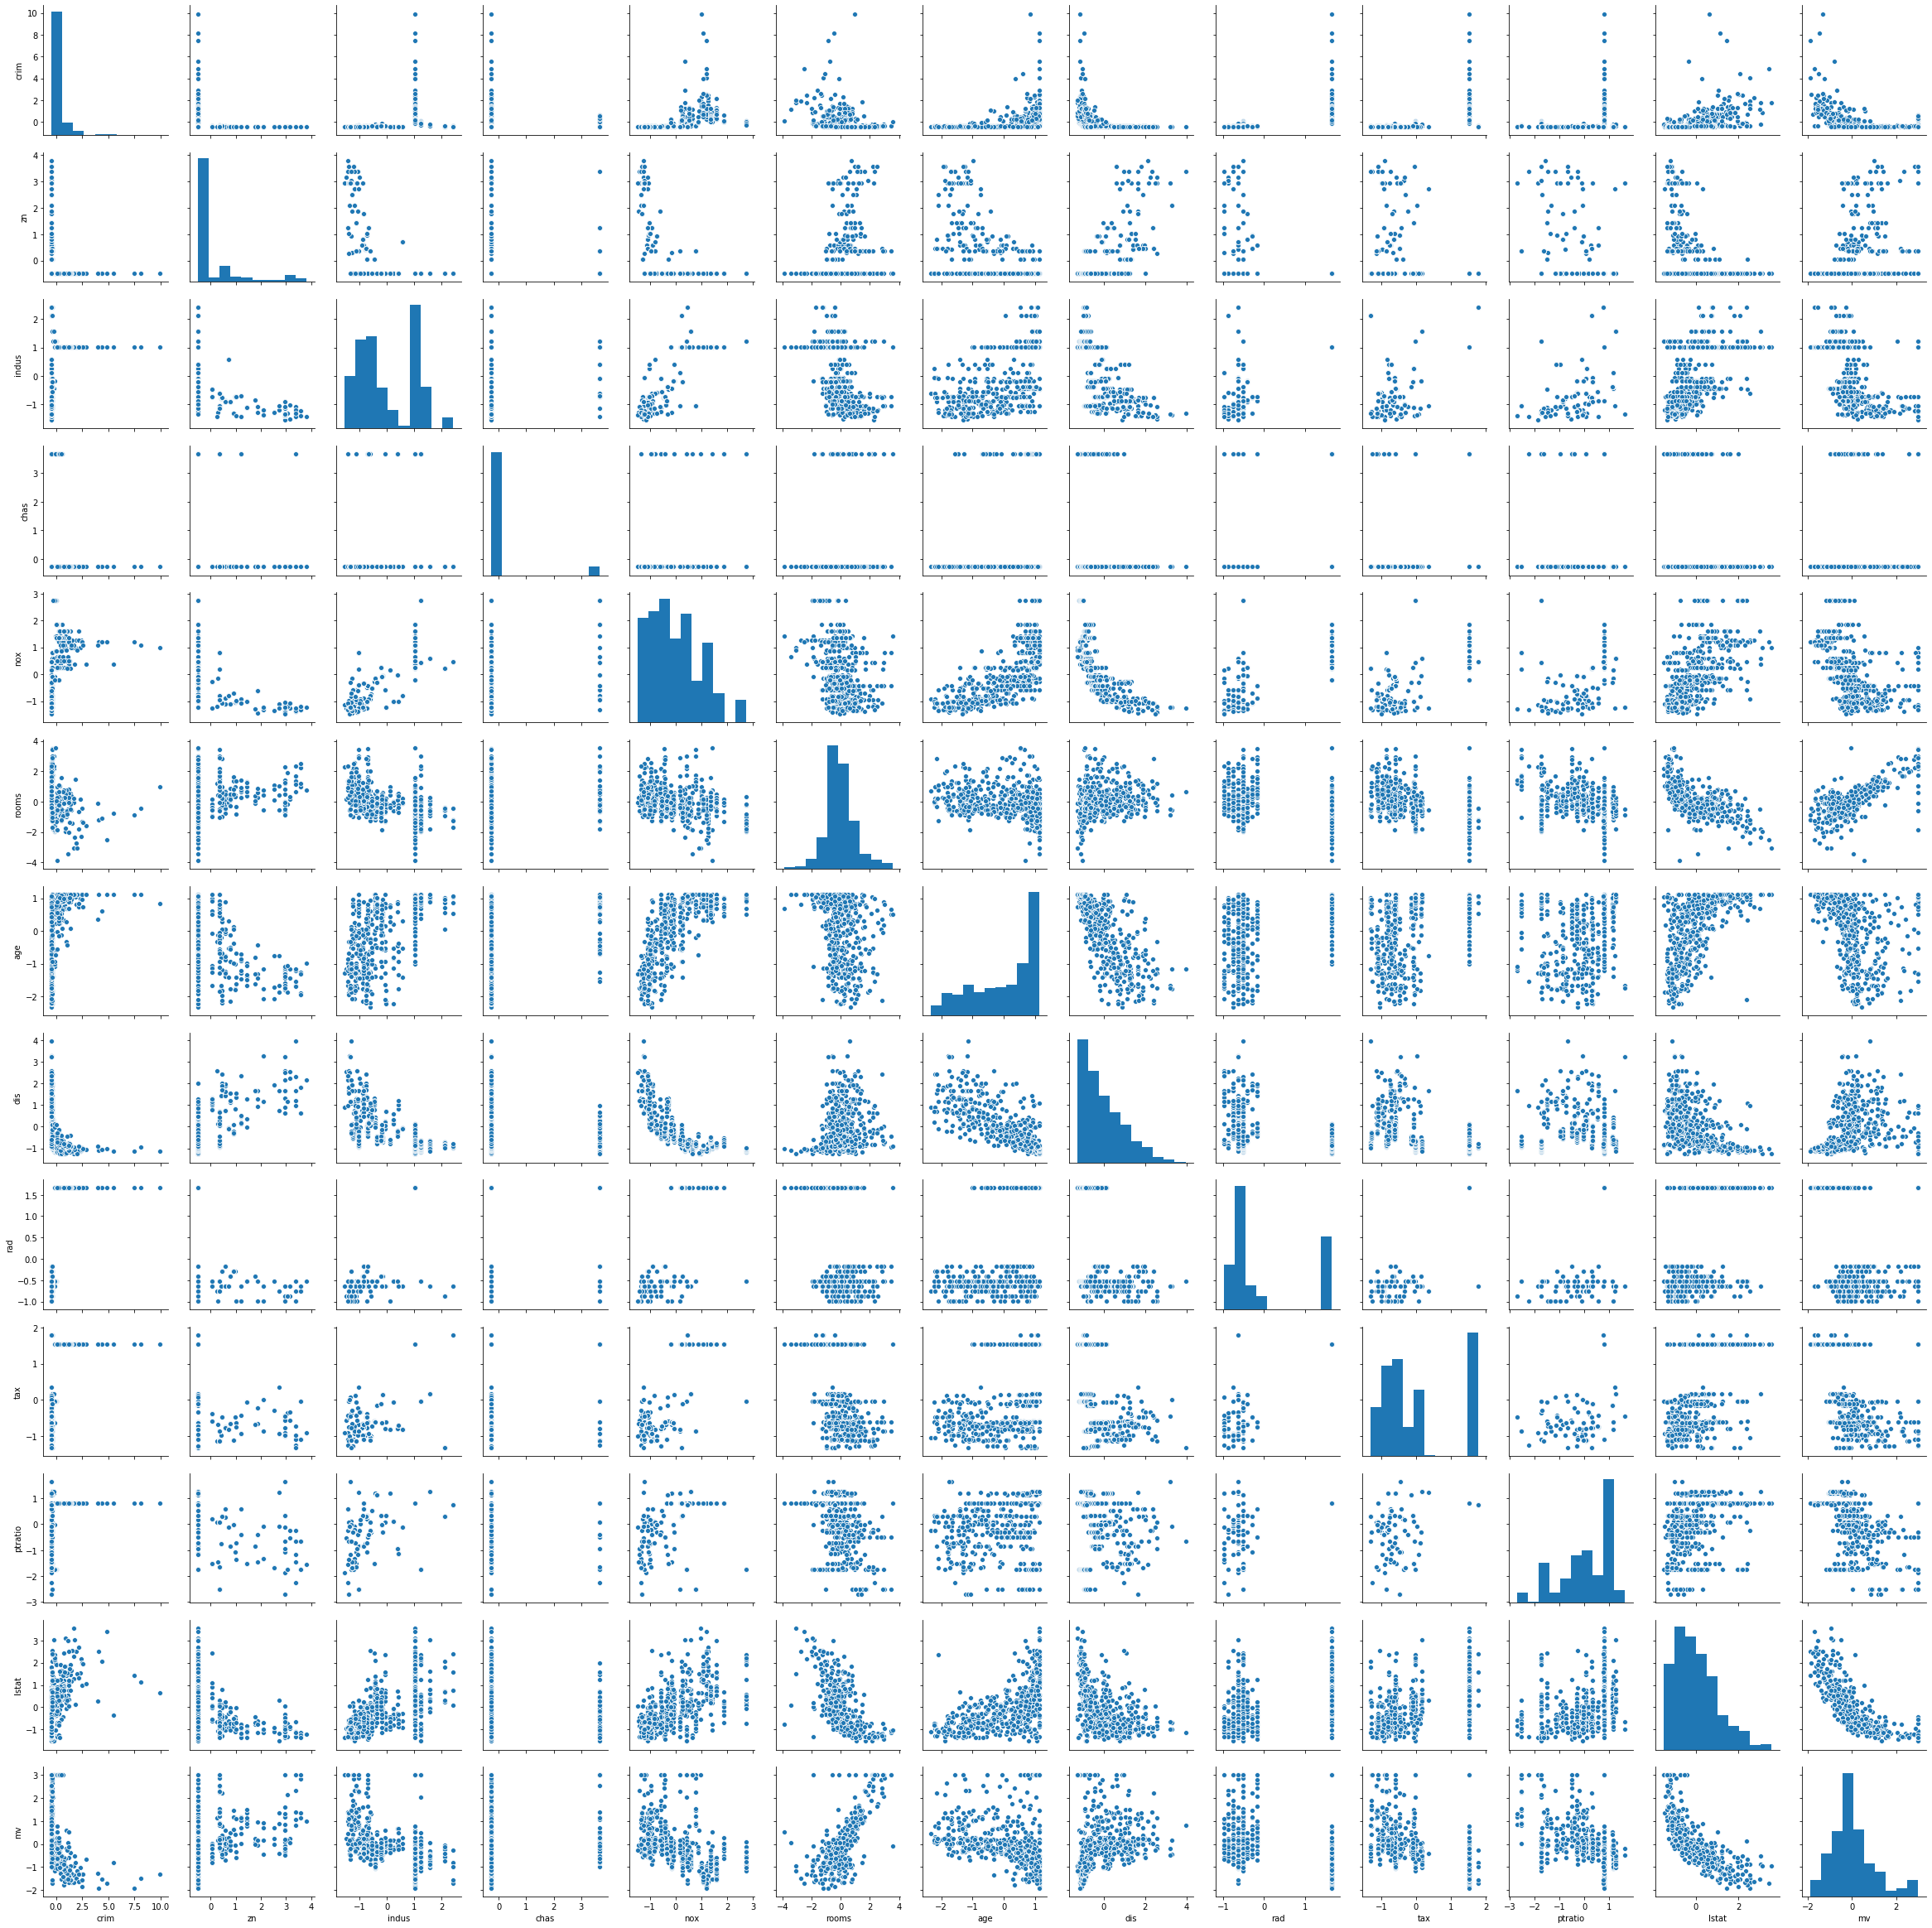

In [25]:
# scatter 
sns.pairplot(scaled, height = 2.5)
plt.show();

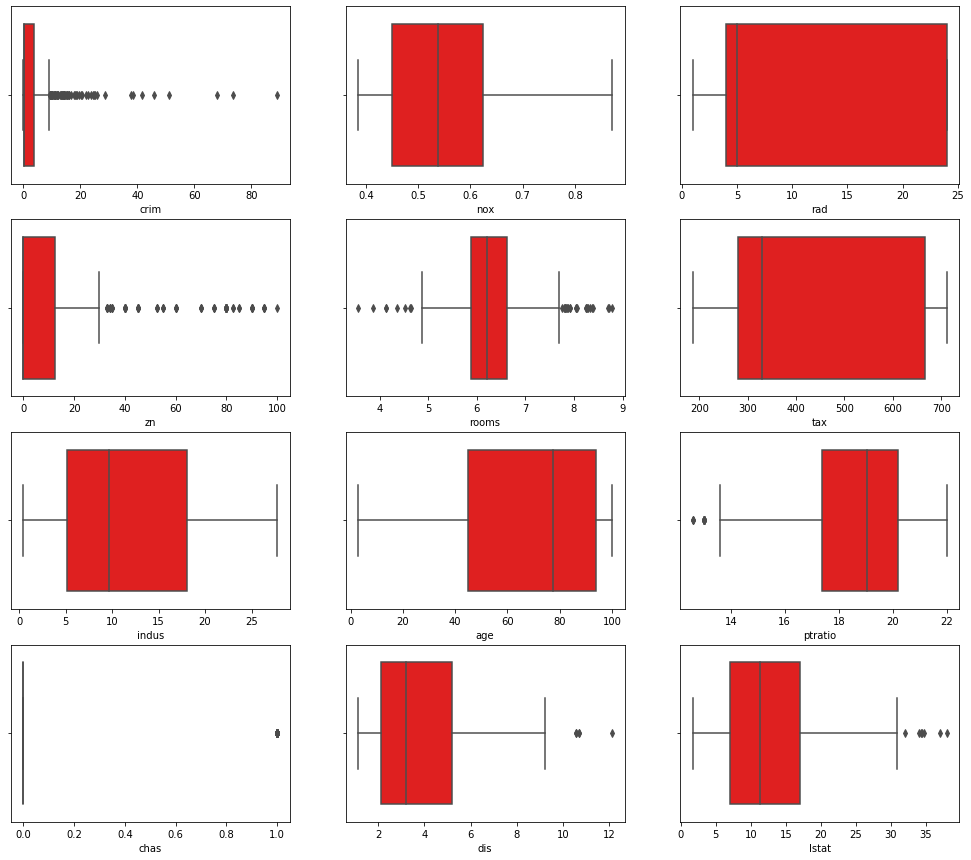

In [26]:
# boxes
f, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (17, 15))

idx = 0
jdx = 0

for x in boston.loc[:, boston.columns != responseVar[0]].columns:
    box = sns.boxplot(x=x,ax=axes[idx,jdx],color='r',data=boston)
    idx += 1
    if idx == 4:
        idx = 0
        if jdx == 0:
            jdx = 1
        elif jdx == 1:
            jdx = 2

<div style="text-align: right"><b> train/test split </b></div>

In [27]:
# Create the train, test data based on 70-30 split of the data
# Use all the explanatory variables, with exception of neighborhood, where response is "mv"

y = scaled[responseVar]
X = scaled.drop(columns = responseVar)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state = 49)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(354, 12) (354, 1)
(152, 12) (152, 1)


<div style="text-align: right"><b> folding </b></div>

In [28]:
RANDOM_SEED = 8675309

In [29]:
folds = KFold(n_splits = 3, shuffle = True, random_state = RANDOM_SEED)

In [30]:
# setup for consolidated table, later
table = {"mv - lin":{"rmse":None,"r2-train":None,"r2-test":None},
         "mv - ridge":{"rmse":None,"r2-train":None,"r2-test":None},
         "mv - lasso":{"rmse":None,"r2-train":None,"r2-test":None},
         "mv - rf":{"rmse":None,"r2-train":None,"r2-test":None},
         "mv - gb":{"rmse":None,"r2-train":None,"r2-test":None},
         "log_mv - lin":{"rmse":None,"r2-train":None,"r2-test":None},
         "log_mv - ridge":{"rmse":None,"r2-train":None,"r2-test":None},
         "log_mv - lasso":{"rmse":None,"r2-train":None,"r2-test":None},
         "log_mv - rf":{"rmse":None,"r2-train":None,"r2-test":None},
         "log_mv - gb":{"rmse":None,"r2-train":None,"r2-test":None}
        }

In [31]:
pd.DataFrame(table).transpose()

,rmse,r2-train,r2-test
mv - lin,None,None,None
mv - ridge,None,None,None
mv - lasso,None,None,None
mv - rf,None,None,None
mv - gb,None,None,None
log_mv - lin,None,None,None
log_mv - ridge,None,None,None
log_mv - lasso,None,None,None
log_mv - rf,None,None,None
log_mv - gb,None,None,None


<div style="text-align: right"><b> model 1 : mv lin reg </b></div>

In [32]:
lin_reg = LinearRegression()

hyper_params = [{'n_features_to_select': list(range(1, 12))}]
rfe = RFE(lin_reg) # for feature selection

model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 0, #1, 2 to make it louder
                        return_train_score=True) 

model_cv.fit(X_train, np.ravel(y_train, order = "C"))
#model_cv.fit(X_train, y_train.values.ravel())

cv_results = pd.DataFrame(model_cv.cv_results_)
#cv_results

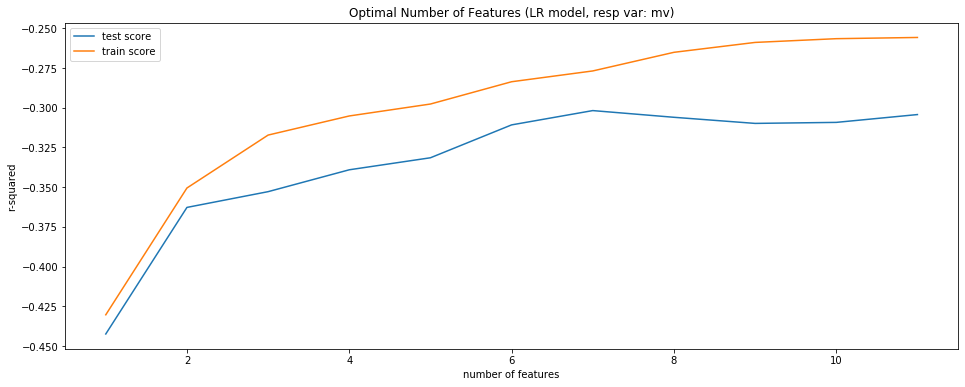

In [33]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features (LR model, resp var: mv)")
plt.legend(['test score', 'train score'], loc='upper left')



In [34]:
# print the best estimator details
print("Optimal number of features : %d" % model_cv.best_estimator_.n_features_)
features=list(X.columns[model_cv.best_estimator_.support_])
print(features)
print('ranking of features:')
model_cv.best_estimator_.ranking_

Optimal number of features : 7
['nox', 'rooms', 'dis', 'rad', 'tax', 'ptratio', 'lstat']
ranking of features:


array([3, 4, 6, 2, 1, 1, 5, 1, 1, 1, 1, 1])

In [35]:
table["mv - lin"]["r2-train"] = round(model_cv.best_estimator_.score(X_train,y_train), 4)
table["mv - lin"]["r2-test"] = round(model_cv.best_estimator_.score(X_test,y_test), 4)
model_cv.best_estimator_

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=7, step=1, verbose=0)

In [56]:
print('RMSE values using best linear regression model (Response var: mv): ')
#use the best model to compute RMSE using CV design
lin_reg = model_cv.best_estimator_ ## Best LR model

lin_reg_scores  = cross_val_score(lin_reg, X, y, scoring=('neg_mean_squared_error'), cv=folds)
lin_rmse_scores = np.sqrt(-lin_reg_scores)
table["mv - lin"]["rmse"] = mean(lin_rmse_scores)
lin_rmse_scores

RMSE values using best linear regression model (Response var: mv): 


array([0.58490579, 0.47669078, 0.52608631])

<div style="text-align: right"> <b> model 2 : mv ridge reg </b></div>

In [37]:
hyper_params = [{'alpha': [0, 0.1, 0.5, 1, 10, 50, 100, 200, 230, 250, 265, 270, 275, 290, 300, 500]}]
model = Ridge() 

model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

model_cv.fit(X_train, y_train)  

cv_results = pd.DataFrame(model_cv.cv_results_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.3s finished


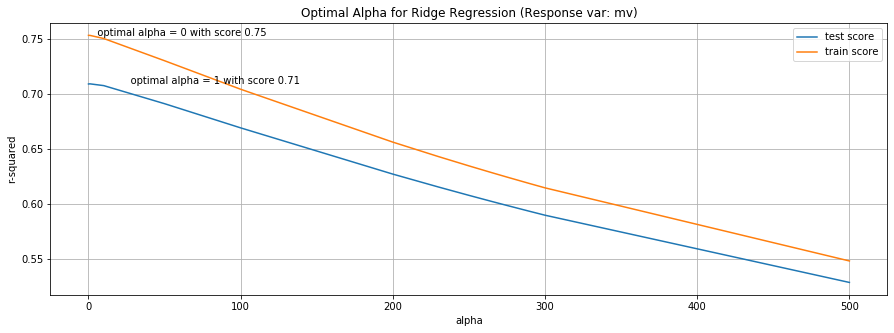

In [38]:
# plotting cv results to visualize optimal alpha
plt.figure(figsize=(15, 5))

plt.plot(cv_results["param_alpha"], cv_results["mean_test_score"])
plt.plot(cv_results["param_alpha"], cv_results["mean_train_score"])
plt.xlabel('alpha')
plt.ylabel('r-squared')
plt.grid()
plt.title("Optimal Alpha for Ridge Regression (Response var: mv)")
plt.legend(['test score', 'train score'], loc='upper right')

orange_y = max(cv_results["mean_train_score"])
orange_x = cv_results[cv_results["mean_train_score"]==max(cv_results["mean_train_score"])].params.values[0]["alpha"] 
blue_y = max(cv_results["mean_test_score"])
blue_x = cv_results[cv_results["mean_test_score"]==max(cv_results["mean_test_score"])].params.values[0]["alpha"]

plt.annotate('   optimal alpha = {} with score {}'.format(orange_x, round(orange_y, 2)), xy=(orange_x, orange_y))
plt.annotate('             optimal alpha = {} with score {}'.format(blue_x, round(blue_y, 2)), xy=(blue_x, blue_y))

plt.show()

In [39]:
print('coefficient of determination - Ridge Regression Model (Training Data + resp var: mv):', model_cv.best_estimator_.score(X_train,y_train))
print('coefficient of determination - Ridge Regression Model (Test Data + resp var: mv):', model_cv.best_estimator_.score(X_test,y_test))

coefficient of determination - Ridge Regression Model (Training Data + resp var: mv): 0.7465326887832452
coefficient of determination - Ridge Regression Model (Test Data + resp var: mv): 0.7016514326300265


In [40]:
print('Best Ridge model (response var: mv): ')
model_cv.best_estimator_

Best Ridge model (response var: mv): 


Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [41]:
print('RMSE values using best Ridge Regression model (Response var: mv): ')
#use the best model to compute RMSE using CV design
ridge_reg = model_cv.best_estimator_ ## Best Ridge model 

ridge_reg_scores  = cross_val_score(ridge_reg, X, y, scoring=('neg_mean_squared_error'), cv=folds)
ridge_rmse_scores = np.sqrt(-ridge_reg_scores)
ridge_rmse_scores

RMSE values using best Ridge Regression model (Response var: mv): 


array([0.45217647, 0.61369295, 0.50454072])

In [42]:
ridge_reg.coef_

array([[-0.09499169,  0.09811308,  0.02251336,  0.09672654, -0.21458375,
         0.26479804,  0.0477427 , -0.31199776,  0.24794305, -0.23491056,
        -0.19794225, -0.51618618]])

<div style="text-align: right"><b> model 3 : log(mv) lin reg </b></div>

In [43]:
# using cross validation design
lin_reg = LinearRegression()

hyper_params = [{'n_features_to_select': list(range(1, 12))}]
rfe = RFE(lin_reg)  

model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 0,
                        return_train_score=True) 

model_cv.fit(X_train, np.ravel(y_train, order = "C"))

cv_results = pd.DataFrame(model_cv.cv_results_)
#cv_results

In [44]:
# plotting cv results
#plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
#plt.xlabel('number of features')
#plt.ylabel('r-squared')
#plt.title("Optimal Number of Features (LR model with with log(mv) as response var)")
#plt.legend(['test score', 'train score'], loc='upper left')

In [45]:
#print("Optimal number of features : %d" % model_cv.best_estimator_.n_features_)
#features=list(X.columns[model_cv.best_estimator_.support_])
#print(features)
#print('ranking of features:')
#model_cv.best_estimator_.ranking_

In [46]:
print('Best Linear Regression model (response var: log(mv)) : {}'.format(model_cv.best_estimator_))

Best Linear Regression model (response var: log(mv)) : RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=7, step=1, verbose=0)


In [47]:
print('coefficient of determination - Linear Regression Model (Training Data + resp var: log(mv)) : {}'.format(round(model_cv.best_estimator_.score(X_train,y_train)), 4))
print('coefficient of determination - Linear Regression Model (Test     Data + resp var: log(mv)) : {}'.format(round(model_cv.best_estimator_.score(X_test,y_test)), 4))

coefficient of determination - Linear Regression Model (Training Data + resp var: log(mv)) : 1.0
coefficient of determination - Linear Regression Model (Test     Data + resp var: log(mv)) : 1.0


In [48]:
print('RMSE values using best linear regression model (Response var: log(mv)): ')
#use the best model to compute RMSE using CV design
lin_reg = model_cv.best_estimator_ ## Best LR model

#Compute the RMSE scores using cross-validation design -- linear regression with log(mv)
lin_reg_scores  = cross_val_score(rfe, X, y, scoring=('neg_mean_squared_error'), cv = folds)
lin_rmse_scores = np.sqrt(-lin_reg_scores)
lin_rmse_scores

RMSE values using best linear regression model (Response var: log(mv)): 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.48430197, 0.64285473, 0.51051835])

<div style="text-align: right"><b>model 4 : log(mv) ridge reg</div></b>

In [49]:
# using cross validation design
folds = KFold(n_splits = 3, shuffle = True, random_state = 100)

#hyper_params = [{'alpha': [0, 0.1, 0.5, 1, 10, 50, 100, 200, 230, 250, 265, 270, 275, 290, 300, 500]}]
hyper_params = [{"alpha": [i + 5 for i in range(0, 100)]}]
model = Ridge() 

model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

model_cv.fit(X_train, y_train)  

cv_results = pd.DataFrame(model_cv.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.6s finished


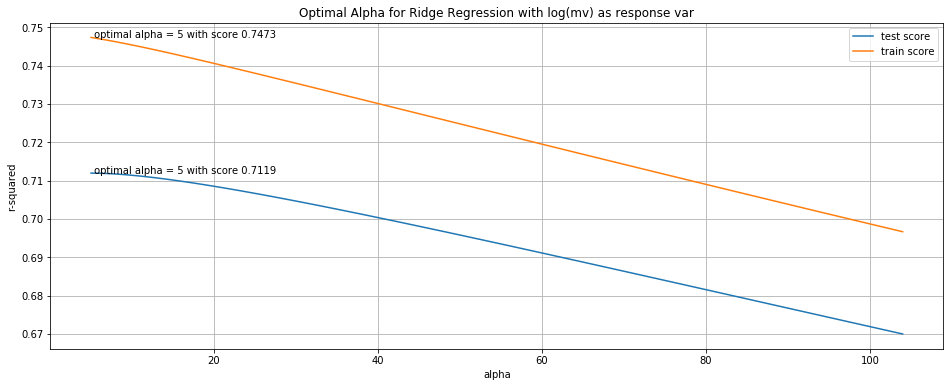

In [50]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_alpha"], cv_results["mean_test_score"])
plt.plot(cv_results["param_alpha"], cv_results["mean_train_score"])
plt.xlabel('alpha')
plt.ylabel('r-squared')
plt.grid()
plt.title("Optimal Alpha for Ridge Regression with log(mv) as response var")
plt.legend(['test score', 'train score'], loc='upper right')

blue_y = max(cv_results["mean_test_score"])
blue_x = cv_results[cv_results["mean_test_score"]==blue_y].params.values[0]["alpha"] 
orange_y = max(cv_results["mean_train_score"])
orange_x = cv_results[cv_results["mean_train_score"]==orange_y].params.values[0]["alpha"] 

plt.annotate(' optimal alpha = {} with score {:.4f}'.format(blue_x, blue_y), xy=(blue_x, blue_y))
plt.annotate(' optimal alpha = {} with score {:.4f}'.format(orange_x, orange_y), xy=(orange_x, orange_y))

plt.show()

In [51]:
print('coefficient of determination - Ridge Regression Model (Training Data + resp var: log(mv)) : {}'.format(round(model_cv.best_estimator_.score(X_train,y_train), 4)))
print('coefficient of determination - Ridge Regression Model (Test     Data + resp var: log(mv)) : {}'.format(round(model_cv.best_estimator_.score(X_test,y_test), 4)))

coefficient of determination - Ridge Regression Model (Training Data + resp var: log(mv)) : 0.7461
coefficient of determination - Ridge Regression Model (Test     Data + resp var: log(mv)) : 0.7032


In [52]:
print('Best Ridge model (response var: log(mv)): ')
model_cv.best_estimator_

Best Ridge model (response var: log(mv)): 


Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [53]:
print('RMSE values using best Ridge Regression model (Response var: log(mv)): ')
#use the best model to compute RMSE using CV design
ridge_reg = model_cv.best_estimator_ ## Best Ridge model 

ridge_reg_scores  = cross_val_score(ridge_reg, X, y, scoring=('neg_mean_squared_error'), cv=folds)
ridge_rmse_scores = np.sqrt(-ridge_reg_scores)
ridge_rmse_scores

RMSE values using best Ridge Regression model (Response var: log(mv)): 


array([0.58490579, 0.47669078, 0.52608631])

In [54]:
ridge_reg.coef_

array([[-0.09175691,  0.08975879,  0.01038468,  0.09803745, -0.20168916,
         0.27026232,  0.04112192, -0.2991599 ,  0.21442907, -0.20285801,
        -0.19470338, -0.50388185]])

<div style="text-align: right"><b> model 5 : mv random forest </div></b>

<div style="text-align: right"><b>model 6 : log(mv) random forest </div></b>

<div style="text-align: right"><b>model 7 : mv gradient boosting </div></b>

<div style="text-align: right"><b>model 8 : log(mv) gradient boosting </div></b>

In [57]:
pd.DataFrame(table).transpose()

,rmse,r2-train,r2-test
mv - lin,0.5292,0.7291,0.6802
mv - ridge,None,None,None
mv - lasso,None,None,None
mv - rf,None,None,None
mv - gb,None,None,None
log_mv - lin,None,None,None
log_mv - ridge,None,None,None
log_mv - lasso,None,None,None
log_mv - rf,None,None,None
log_mv - gb,None,None,None
